# Part 2: Algorithms for the linear least squares problem

Recall the linear regression problem: given a data matrix, $X$, and responses $y$, we wish to determine the model parameters $\theta^*$ that minimizes $\|X \theta - y\|_2^2$. This problem is also known as the _linear least squares_ problem.

Numpy has a function, [np.linalg.lstsq()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html), that will compute linear least squares solutions for you. However, the purpose of this notebook is to give you a sense of how `lstsq()` works. So, instead of using it as a black box, you'll study how one might implement `lstsq()` using two different numerical algorithms.

> You may rightly ask, why bother with such details? Here are three reasons it's worth looking more closely.
>
> 1. It's helpful to have some deeper intuition for how one formalizes a mathematical problem and derives a computational solution, in case you ever encounter a problem that does not exactly fit what a canned library can do for you.
>
> 2. If you have ever used a statistical analysis package, it's likely you have encountered "strange" numerical errors or warnings. Knowing how problems are derived can help you understand what might have gone wrong. We will see an example below.
>
> 3. Because data analysis is quickly evolving, it's likely that new problems and new models will not exactly fit the template of existing models. Therefore, it's possible you will need to derive a new model or know how to talk to someone who can derive one for you.

## Aside: The "reconditioning" idea ##

To understand what is happening later on in this notebook, it's helpful to have a quick and simple example that should give you the right intuition.

Suppose you are asked to write some code that implements the following formula:

$$z = \log_{10} (x^2).$$

For example, let $x = 10^{154}$. Then $z = 308$. Notice that both the input, $10^{154}$, and the output, 308, can be represented in IEEE double-precision (64-bit) floating-point.

> Do you remember the maximum allowable positive value?

Indeed, here is one natural approach: first calculate $y = x^2$, then return $\log_{10} y$. Easy peasy, right?

In [1]:
def log10_arg2(x):
    from math import log10
    y = x ** 2
    return log10(y)

# Demo
print("Let x =", 1e154, " and observe that `log10_arg2(1e154)` is", log10_arg2(1e154))

Let x = 1e+154  and observe that `log10_arg2(1e154)` is 308.0


Next, let's try $x = 10^{155}$. The output should be 310, which is only slightly larger than 308. But what happens?

In [2]:
# Demo: What happens?
try:
    print("Let x =", 1e155, ". Then `log10_arg2(x)` is:")
    print(log10_arg2(1e155))
except OverflowError as e:
    print("*** An error occurred! *** ==>", e)
finally:
    pass

Let x = 1e+155 . Then `log10_arg2(x)` is:
*** An error occurred! *** ==> (34, 'Numerical result out of range')


What is the problem? Analytically, `y` should get the value $(10^{155})^2 = 10^{310}$, but observe what happens when you try to print the value $10^{310}$:

In [3]:
print(1e310)

inf


The value is out of the range of the floating-point representation. Put differently, the method implemented previously can be numerically unstable for an input that is large enough.

How do you fix it? In this case, let's use a little bit of math to massage the calculation into an equivalent form:

$$z = \log_{10} (x^2) = 2 \log_{10} x.$$

As long as $\log_{10} x$ is within a factor of 2 of what can be represented, we should be able to get an answer. Let's give it a try.

In [4]:
def log10_arg2_take2(x):
    from math import log10
    return 2 * log10(x)

print(log10_arg2_take2(1e155)) # Should work!
print(log10_arg2_take2(1e308)) # This one, too, even though 10^(308) is close the max possible float

310.0
616.0


Even when $x$ is barely in the range of what you can store in floating-point (around $10^{308}$), the function still works!

**Takeaway.** The key principle from the preceding exercise is sometimes you can make a fragile method less fragile by using just the right transformation. The remainder of this notebook is about the analogue of this idea as it applies to the linear regression problem. The result are much more numerically robust methods.

## On with the show ... ##

**Implementation note.** In this notebook, we ask that you use the following convention: any column vector should be _explicit_. That means its shape should have two dimensions where the column dimension equals one (1).

**Exercise 0** (ungraded). Inspect the following code cell and make sure you understand the difference between two conventions for storing a vector, namely, as a one-dimensional array versus as a two-dimensional array (matrix) where the number of columns equals one (1). When you are asked to produce a vector, we will generally ask you to follow the second convention (`z_colvec`).

In [5]:
import numpy as np

# By default, Numpy vectors constructed from a list are 1-D
# and have neither a row nor a column orientation.
z_array = np.array([1.0, 2.0, 3.0])

# By contrast, we want you to ensure your vectors are
# column vectors.
z_colvec = np.reshape(z_array, (len(z_array), 1))

print("`z_array`:\n\n", z_array, "\n\n==> shape:", z_array.shape)
print("\n")
print("`z_colvec`:\n\n", z_colvec, "\n\n==> shape:", z_colvec.shape)

`z_array`:

 [1. 2. 3.] 

==> shape: (3,)


`z_colvec`:

 [[1.]
 [2.]
 [3.]] 

==> shape: (3, 1)


Before beginning, run this code cell to load some of the key modules you'll need.

In [6]:
# Data and computation
import numpy as np
import scipy as sp
import scipy.linalg
import pandas as pd

# Timing
from cse6040bench import benchit

# Viz
from IPython.display import display, Math
from matplotlib.pyplot import figure, subplot, xlim, ylim
from matplotlib.pyplot import scatter, axis, xlabel, ylabel, title, plot
%matplotlib inline

# Some functions we'll use later to display results
def show_cond_fancy(x, name, opt=''):
    """Display a condition number in 'fancy' format (using LaTeX)."""
    def sci_to_latex(x, fmt='{:.2e}'):
        s_raw = fmt.format(x)
        s, e = s_raw.split('e')
        return s + r'\times 10^{{{}}}'.format(int(e))
    from IPython.display import Math
    x_s = sci_to_latex(x)
    display(Math(r'\kappa({}){} \approx {}'.format(name, opt, x_s)))
    
def show_2vecs_tibble(x, y, xname='x', yname='y', error=False):
    """Display two column vectors side-by-side in a tibble."""
    assert type(x) is np.ndarray and x.ndim >= 2 and x.shape[1] == 1
    assert type(y) is np.ndarray and y.ndim >= 2 and y.shape[1] == 1
    assert x.shape == y.shape
    x_df = pd.DataFrame(x, columns=[xname])
    y_df = pd.DataFrame(y, columns=[yname])
    df = pd.concat([x_df, y_df], axis=1)
    if error:
        df['error'] = x - y
    display(df)
    
# Display (X, y) problem as a tibble
def make_data_tibble(X, y=None):
    df = pd.DataFrame(X, columns=['x_{}'.format(i) for i in range(X.shape[1])])
    if y is not None:
        y_df = pd.DataFrame(y, columns=['y'])
        df = pd.concat([y_df, df], axis=1)
    return df
    
# From: https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
def nparray_to_bmatrix(a):
    """Returns a LaTeX bmatrix"""
    assert len(a.shape) <= 2, 'bmatrix can at most display two dimensions'
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

# Stash this function for later:
SAVE_LSTSQ = np.linalg.lstsq # You may ignore this line, which some test cells will use

Matplotlib is building the font cache; this may take a moment.


## Notation and review

Here is a quick summary of how we can formulate and approach the linear regression problem. For a more detailed derivation, see these [accompanying notes](./notes-linreg.ipynb).

Your data consists of $m$ observations and $n+1$ variables. One of these variables is the _response_ variable, $y$, which you want to predict from the other $n$ variables, $\{x_0, \ldots, x_{n-1}\}$. You wish to fit a _linear model_ of the following form to these data,

$$y_i \approx x_{i,0} \theta_0 + x_{i,1} \theta_1 + \cdots + x_{i,n-1} \theta_{n-1} + \theta_n,$$

where $\{\theta_j | 0 \leq j \leq n\}$ is the set of unknown coefficients. Your modeling task is to choose values for these coefficients that "best fit" the data.

If we further define a set of dummy variables, $x_{i, n} \equiv 1.0$, associated with the $\theta_n$ parameter, then the model can be written more compactly in matrix notation as

$$
  y \approx X \theta,
$$

where we will refer to $X$ as the (input) data matrix.

Visually, you can also arrange the observations into a tibble like this one:

|     y      | x<sub>0</sub> | x<sub>1</sub> | $\cdots$ | x<sub>n-1</sub> | x<sub>n</sub> |
|:----------:|:-------------:|:-------------:|:--------:|:---------------:|:-------------:|
|   $y_0$    |   $x_{0,1}$   |   $x_{0,2}$   | $\cdots$ |   $x_{0,n-1}$   |      1.0      |
|   $y_1$    |   $x_{1,1}$   |   $x_{1,2}$   | $\cdots$ |   $x_{1,n-1}$   |      1.0      |
|   $y_2$    |   $x_{2,1}$   |   $x_{2,2}$   | $\cdots$ |   $x_{2,n-1}$   |      1.0      |
|  $\vdots$  |   $\vdots$    |   $\vdots$    | $\vdots$ |    $\vdots$     |      1.0      |
|  $y_{m-1}$ |  $x_{m-1,1}$  |  $x_{m-1,2}$  | $\cdots$ |  $x_{m-1,n-1}$  |      1.0      |

This tibble includes an extra column (variable), $x_n$, whose entries are all equal to 1.0.

**Synthetic problem generator.** For the exercises in this notebook, we will generate synthetic data. The function, `gen_problem(m, n)`, will return a triple, `X`, `y`, `theta`, which are an `m` x (`n`+1) data matrix `X`, a response vector `y`, and the "true" model parameters `theta`. We will then run two different numerical algorithms that estimate `theta` from `X` and `y`, and see how their answers compare against the true value.

> **Note 1.** The problem generator constructs the data matrix $X$ such that each entry $(i, j)$ is $i^{\,j}$. This structure makes it an instance of a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix), which arises when fitting a polynomial to data. The "true" parameter vector $\theta$ is set to all ones, and $y$ computed simply by summing the rows.
>
> **Note 2.** Although our usual convention is to make the _last_ column all ones, the Vandermonde matrix has its _first_ column set to all ones. This ordering is not important in this problem, but it does mean one would interpret $\theta_0$ as the intercept rather than $\theta_{n}$, which will be our usual convention.

In [7]:
def gen_problem(m, n):
    from numpy import arange, tile, cumprod, insert, ones
    # 1 + x + x^2 + ... + x^n, x = 0:m
    X = np.empty((m, n+1))
    x_col = arange(m).reshape((m, 1)) # 0, 1, 2, ..., m-1
    X[:, 0] = 1.0
    X[:, 1:] = tile(x_col, reps=(1, n))
    X[:, 1:] = cumprod(X[:, 1:], axis=1)
    theta = ones((n+1, 1))
    y = np.sum(X, axis=1).reshape((m, 1))
    return X, y, theta

print("Sample generated problem:")
m, n = 10, 2
X, y, theta_true = gen_problem(m, n)

display(Math(r'X = {}, \quad y = {} \quad \implies \quad \theta^* = {}'.format(nparray_to_bmatrix(X),
                                                                               nparray_to_bmatrix(y),
                                                                               nparray_to_bmatrix(theta_true))))

Sample generated problem:


<IPython.core.display.Math object>

We are interested primarily in _overdetermined systems_, meaning $X$ has more rows than columns, i.e., $m > n+1$, as shown above. That's because typically we have more observations (data points, or rows) than predictors (variables or columns). For such problems, there is generally no unique solution.

Therefore, to identify some solution, we need to ask for the "best" fit and say what we mean by "best." For linear regression, the usual definition of "best" is _minimizing_ the sum-of-squared residual error:

$$ \theta^* = {\arg\min_\theta} \|X \theta - y\|_2^2. $$

Solving this minimization problem is equivalent to solving a special system known as the _normal equations_,

$$
  X^T X \theta^* = X^T y.
$$

So, our computational task is to solve this problem.

## Algorithm 1: Direct solution of the normal equations

The preceding calculation immediately suggests the following algorithm to estimate $\theta^*$. Given $X$ and $y$:

1. Form $C \equiv X^T X$. This object is sometimes called the [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) or Gramian of $X$.
2. Form $b \equiv X^T y$.
3. Solve $C \theta^* = b$ for $\theta^*$.

But, is this a "good" algorithm? There are at least three dimensions along which we might answer this question.

1. Is it accurate enough?
2. Is it fast enough?
3. Is it memory-efficient enough?

Let's examine these questions by experiment.

**Exercise 1** (3 points). Implement a function, `solve_neq(X, y)` that implements Algorithm 1. It should return a Numpy vector containing the model parameter estimates.

Recall the steps of the algorithm as previously outlined:

1. Form the Gramian of $X$, $C \equiv X^T X$.
2. Form $b \equiv X^T y$.
3. Solve $C \theta^* = b$ for $\theta^*$.

Your algorithm should carry out these steps. For the third step, use Scipy's routine, [`scipy.linalg.solve()`](https://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html#solving-linear-system). It has an option that allows you to indicate that $C$ is symmetric and positive definite, which will be true of $C$ for our synthetic problem.

> The code cell will run your function to compute a set of parameter estimates. It will store these in a variable named `theta_neq`, which we will refer to later.

In [8]:
def solve_neq(X, y):
    
    A = X.T.dot(X)
    b = X.T.dot(y)
    theta_star = scipy.linalg.solve(A, b)
    return theta_star

theta_neq = solve_neq(X, y)

print("Your implementation's solution versus the true solution:")
show_2vecs_tibble(theta_neq, theta_true, xname='theta_neq', yname='theta_true', error=True)

Your implementation's solution versus the true solution:


,theta_neq,theta_true,error
0,1.0,1.0,-1.498801e-14
1,1.0,1.0,1.310063e-14
2,1.0,1.0,-1.443290e-15


In [9]:
# Test cell: `solve_neq_test`

try:
    del np.linalg.lstsq
    solve_neq(X, y)
except NameError as n:
    if re.findall('lstsq', n.args[0]):
        print("*** Double-check that you did not try to use `lstsq()`. ***")
    raise n
except AttributeError as a:
    if re.findall('lstsq', a.args[0]):
        print("*** Double-check that you did not try to use `lstsq()`. ***")
    raise a
finally:
    np.linalg.lstsq = SAVE_LSTSQ

assert type(theta_neq) is np.ndarray, "`theta_neq` should be a Numpy array, but isn't."
assert theta_neq.shape == (n+1, 1), "`theta_neq.shape` is {} instead of {}.".format(theta_neq.shape, (n+1, 1))

assert (np.abs(theta_neq - theta_true) <= 1e-12).all(), \
       "Your `theta_neq` does not match the true solution, `theta_true`."

print("\n(Passed!)")


(Passed!)


**Exercise 2** (1 point). Write a function to calculate the residual norm, $\|r\|_2 = \|X \theta^* - y\|_2$.

> Although we are minimizing $\|r\|_2^2$, for this exercise your function should return $\|r\|_2$.

In [10]:
def calc_residual_norm(X, y, theta):
    
    r = np.linalg.norm(X.dot(theta) - y)
    return r

r_norm_neq = calc_residual_norm(X, y, theta_neq)
print("\nThe squared residual norm:", r_norm_neq)


The squared residual norm: 3.513658552879787e-14


In [11]:
# Test cell: `calc_residual_norm_test`

r_norm_neq = calc_residual_norm(X, y, theta_neq)
assert 1e-16 <= np.abs(r_norm_neq) <= 1e-12
print ("\n(Passed.)")


(Passed.)


## Sources of error

We said before that one question we should ask about our algorithm is whether it is "accurate enough." But what does that mean?

**Exercise 3** (ungraded). For any modeling problem, there will be several sources of error. Describe at least three such sources.

**Answer.** Here are some possibilities.

1. There will be errors in the inputs. That is, the data itself may only represent measurements of a certain accuracy.
2. There will be errors in the model. That is, the model is only an approximation of the underlying phenomena.
3. There will be errors in the algorithm. That is, you may implement an algorithm that can only approximately estimate the parameters of the model.
4. There will be roundoff errors. Recall that floating-point arithmetic necessarily represents all values finitely, which means you may lose accuracy every time you do an arithmetic operation.

**Perturbations.** One way to understand error in a numerical computation is to consider how sensitive the computed solution is to perturbations to the input.

That is, suppose we change $X$ by an amount $\Delta X$. We can then ask by how much the computed model parameters $\theta^*$ change. If they change by a lot, then our method for computing them may be overly sensitive to perturbations. Instead, we might prefer one method over another one that is more sensitive to changes.

Let's see how Algorithm 1 fares under small perturbations. But first, we'll need a method to generate a random perturbation of a certain maximize size.

**Exercise 4** (2 points). Implement a function that returns an $m \times n$ matrix whose entries are uniformly randomly distributed in the interval, $[0, \epsilon]$ for a given value of $\epsilon$.

> Hint: Check out Numpy's module for generating (pseudo)random numbers: [`numpy.random`](https://docs.scipy.org/doc/numpy/reference/routines.random.html)

In [12]:
def random_mat (m, n, eps):
    
    uniform_trix = np.random.uniform(low=0.0, high=eps, size=(m, n))
    return uniform_trix

print(random_mat(3, 2, 1e-3))

[[6.08620555e-04 7.43188391e-04]
 [1.08019517e-04 1.17241130e-07]
 [2.84811806e-05 4.29240666e-04]]


In [13]:
# Test cell: `rand_eps_test`

Z = random_mat (5, 3, 1e-2)
assert Z.shape == (5, 3)
assert ((Z >= 0) & (Z <= 1e-2)).all()
print("\n(Passed.)")


(Passed.)


**Exercise 5** (2 points). Use your `random_mat()` function to write another function, `perturb_system(X, y, eps)`, that creates two "perturbations" to the system defined by `X` and `y`.

1. Let $\Delta X$ be the first perturbation. It should have the same dimensions as $X$, and its entries should lie in the interval $[-\epsilon, \epsilon]$. The value of $\epsilon$ is given by `eps`.
2. The second is $\Delta y$, a small perturbation to the response variable, $y$. Its entries should also lie in the same interval, $[-\epsilon, \epsilon]$, 

Your function should return a perturbed system, $X + \Delta X$ and $y + \Delta y$, as a pair.

In [14]:
def perturb_system(X, y, eps):
    
    Delta_X = random_mat(X.shape[0], X.shape[1], 2*eps) - eps
    Delta_y = random_mat(y.shape[0], y.shape[1], 2*eps) - eps
    return X + Delta_X, y + Delta_y

EPSILON = 0.1
X_perturbed, y_perturbed = perturb_system(X, y, EPSILON)

Delta_X = X_perturbed - X
Delta_y = y_perturbed - y
display(Math(r'\Delta X = {}, \quad \Delta y = {}'.format(nparray_to_bmatrix(Delta_X[:5, :]),
                                                          nparray_to_bmatrix(Delta_y[:5]))))

<IPython.core.display.Math object>

In [15]:
# Test cell: `delta_X_test`

Delta_X = X_perturbed - X
Delta_y = y_perturbed - y

assert Delta_X.shape == X.shape, "`Delta_X` has shape {} instead of {}.".format(Delta_X.shape, X.shape)
assert (np.abs(Delta_X) <= EPSILON).all(), "The perturbation lies outside the interval, [-{}, {}]".format(EPSILON, EPSILON)

assert Delta_y.shape == y.shape, "`Delta_y` has shape {} instead of {}.".format(Delta_y.shape, y.shape)
assert (np.abs(Delta_y) <= EPSILON).all(), "The perturbation lies outside the interval, [-{}, {}]".format(EPSILON, EPSILON)

# Should replace with multiple trials and a proper distribution test:
assert (Delta_X < 0).sum() > 0, "Something's fishy -- Delta_X has *no* negative entries? (Possible but highly unlikely)"
assert (Delta_y < 0).sum() > 0, "Something's fishy -- Delta_y has *no* negative entries? (Possibly but highly unlikely)"

print ("\n(Passed.)")


(Passed.)


### Sensitivity of Algorithm 1

Let's now run the following code, which uses your code from above to perform a "sensitivity experiment." In particular, the function `run_perturbation_trials()` will repeatedly perturb the system and measure the resulting change to the estimated $\theta^*$.

All of the estimated $\theta^*$ are stored in an array, `Thetas_neq`. Each _column_ `k` of `Thetas_neq`, or `Thetas_neq[:, k]`, is one of the calculated estimates under a random perturbation of the system.

The size of the random perturbation is set, by default, to `eps=0.01`. Recall that our synthetic problem consists of numerical values that are all greater than or equal to one, so this perturbation may be regarded as fairly small.

In [16]:
def run_perturbation_trials(solver, X, y, eps=0.01, trials=100):
    Thetas = np.zeros((X.shape[1], trials)) # Store all computed thetas
    for t in range(trials):
        X_p, y_p = perturb_system(X, y, eps)
        Thetas[:, t:t+1] = solver(X_p, y_p)
    return Thetas

Thetas_neq = run_perturbation_trials(solve_neq, X, y)

print("Unperturbed solution:")
print(theta_neq)

print("First few perturbed solutions (columns):")
print(Thetas_neq[:, :5])

Unperturbed solution:
[[1.]
 [1.]
 [1.]]
First few perturbed solutions (columns):
[[0.99395993 1.00298699 0.99977238 0.9863678  1.00794398]
 [1.00436436 0.99730899 0.99896743 1.00365293 0.99556794]
 [0.99957245 1.0002763  1.0001499  0.9999182  1.00048068]]


Here is a quick plot of the that shows two coordinates of the true parameters (red star), compared to all perturbed estimates (blue points). We would have more confidence in the algorithm's computed solutions if it did not appear to be too sensitive to changes in the input.

Since $\theta$ may have more than two coordinates, the code below shows the first two coordinates.

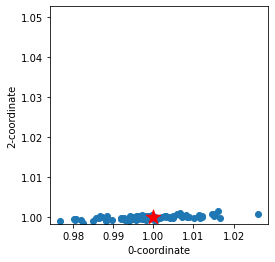

In [17]:
# Makes a 2-D scatter plot of given theta values.
# If the thetas have more than two dimensions, only
# the first and last are displayed by default.
# (Override by setting ax and ay.)

def scatter_thetas(Thetas, theta_true=None, ax=0, ay=-1, xylim=None, title=None):
    import matplotlib.pyplot as plt
    assert type(Thetas) is np.ndarray and Thetas.shape[0] >= 2
    scatter(Thetas[ax, :], Thetas[ay, :])
    xlabel('{}-coordinate'.format(ax if ax >= 0 else Thetas.shape[0]+ax))
    ylabel('{}-coordinate'.format(ay if ay >= 0 else Thetas.shape[0]+ay))
    if xylim is not None:
        axis(xylim)
    else:
        axis('equal')
    if theta_true is not None:
        assert type(theta_true) is np.ndarray and theta_true.shape[0] >= 2 and theta_true.shape[1] == 1
        scatter(theta_true[ax], theta_true[ay], marker='*', color='red', s=15**2)
    if title is not None:
        plt.title(title)
        
def calc_lims(x, buffer=0.1):
    xmin = x.min()
    xmax = x.max()
    dx = (xmax - xmin) * buffer
    return xmin-dx, xmax+dx
        
scatter_thetas(Thetas_neq, theta_true=theta_true, ax=0, ay=2)
axis('square');

You should observe that the change in the estimates are of the same order as the perturbation. So for this example system, the algorithm seems reliable enough.

## Stress-testing Algorithm 1

This experiment suggests all is fine. But what should we _expect_ to happen?

We've prepared another [notebook](./notes-cond.ipynb) that walks you through an analysis of solving linear systems. It turns out you can estimate how hard it is to solve a linear system using a measure called the _condition number_. We can denote the condition number of solving a system by $\kappa(X)$ where $X$ is the matrix. The larger this number is, the more sensitive the problem is.

In Numpy, there is a condition number estimator that will tell us approximately what the condition number is for a given matrix. Let's compare $\kappa(X)$ and $\kappa(C) = \kappa(X^TX)$:

In [18]:
cond_X = np.linalg.cond(X)
cond_XTX = np.linalg.cond(X.T.dot(X))

assert 1. <= cond_X <= 3e3
assert 1. <= cond_XTX <= 6e6

show_cond_fancy(cond_X, 'X')
show_cond_fancy(cond_XTX, 'X^T X')
show_cond_fancy(cond_X**2, 'X', opt='^2')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Ill-conditioning.** As it happens, $\kappa(C)$ is roughly the **square** of $\kappa(X)$. So, by forming $C$ explicitly and then trying to solve a system based on it, we make the problem _more_ difficult. Indeed, if the problem is ill-conditioned enough, this algorithm based on directly constructing the normal equations will produce very different results even under small changes, and we call the algorithm _unstable_.

In this particular example, the condition numbers are not very "big." You would be more concerned if the condition numbers were close to $1/\epsilon$, where $\epsilon$ is machine epsilon. In double-precision, recall that $\epsilon_d \approx 10^{-15}$, so the values shown above are nothing to be worried about.

But what if we had a "hard" problem, that is, one whose condition number is large? The synthetic data generator allows us to create such a problem by making the problem bigger. Let's try that next. (To do this, we'll increase the size of the above-described Vandermonde matrix from $(i,j)=(10,2)$ to $(i,j)=(100,6)$.)

In [19]:
# Generate a "hard" problem
m_hard, n_hard = 100, 6
X_hard, y_hard, theta_hard_true = gen_problem(m_hard, n_hard)

df_hard = make_data_tibble(X_hard, y_hard)
print("First few rows of data:")
df_hard.head()
print("True parameter estimates:\n{}".format(theta_hard_true))

cond_X_hard = np.linalg.cond(X_hard)
cond_XTX_hard = np.linalg.cond(X_hard.T.dot(X_hard))

name_X_hard = 'X_h'
show_cond_fancy(cond_X_hard, name_X_hard)
show_cond_fancy(cond_XTX_hard, '{}^T {}'.format(name_X_hard, name_X_hard))

First few rows of data:
True parameter estimates:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

These condition numbers are much larger. So, let's run the same sensitivity experiment as before, and see how the estimate varies for the hard problem. How does it compare to the well-conditioned case?

Residual norm for one of the trials:


<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.78696e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)
<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.78446e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)
<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.79115e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)
<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.84135e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)
<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.82725e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)
<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.84913e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)
<ipython-input-8-dd77af09b269>:5: 

198658184886686.8

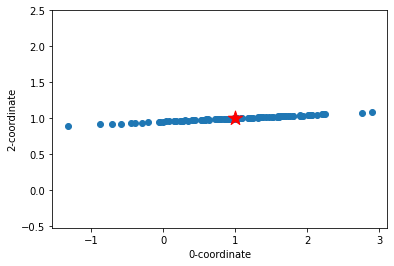

In [20]:
Thetas_hard_neq = run_perturbation_trials(solve_neq, X_hard, y_hard)
scatter_thetas(Thetas_hard_neq, theta_true=theta_hard_true, ax=0, ay=2)

print("Residual norm for one of the trials:")
theta_hard_neq_example = np.random.randint(Thetas_hard_neq.shape[1])
calc_residual_norm(X_hard, y_hard, theta_hard_neq_example)

Observe that the computed estimates can be relatively far from the true value, even getting the sign completely wrong in the case of the $\theta_0$.

## Algorithm 2: QR decomposition

A different method for solving an overdetermined systems is to use a tool from linear algebra known as the [_QR decomposition_](https://en.wikipedia.org/wiki/QR_decomposition). It is analogous to the $z = \log_{10} (x^2)$ example from before.

Here is how we can use QR. If $X$ has linearly independent columns, then we would first factor the $m \times n$ matrix $X$ into the product $X = QR$, where $Q$ is an $m \times n$ orthogonal matrix and $R$ is an invertible $n \times n$ upper-triangular matrix. (These dimensions assume $m \geq n$.) That $Q$ is orthogonal means that $Q^T Q = I$, the identity matrix; $R$ being upper-triangular means all of its entries below the main diagonal are zero.

Next, observe that the normal equations can be transformed if we substitute $X = QR$:

$$
\begin{eqnarray}
        X^T X \theta^* & = & X^T y \\
  R^T Q^T Q R \theta^* & = & R^T Q^T y \\
            R \theta^* & = & Q^T y.
\end{eqnarray}
$$

Lastly, because $R$ is triangular, solving a system is "easy" using _(backward) substitution_. Consider the following $3 \times 3$ example (taken from [here](http://www.purplemath.com/modules/systlin6.htm)):

$$
\left[\begin{matrix}
5 &  4 & -1 \\
  & 10 & -3 \\
  &    &  1 \\
\end{matrix}\right]
\cdot
\left[\begin{matrix}
  \theta_0 \\
  \theta_1 \\
  \theta_2
\end{matrix}\right]
=
\left[\begin{matrix}
  0 \\
  11 \\
  3
\end{matrix}\right].
$$

Because it is upper-triangular, you can see right away that $1 \cdot \theta_2 = 3 \implies \theta_2 = 3$. Then, going to the equation above it, $10 \theta_1 - 3 \theta_2 = 10 \theta_1 - 3(3) = 11 \implies \theta_1 = 2$. Lastly, $5 \theta_0 + 4 \theta_1 - \theta_2 = 5 \theta_0 + 4(2) - 3 = 0 \implies \theta_0 = -1$.

So, to summarize, a different algorithm to solve $X \theta^* \approx y$ using QR would look like the following:

1. Compute $X = QR$.
2. Form the modified right-hand side, $z = Q^T y$.
3. Use back-substitution to solve $R \theta^* = z$.

**Conditioning.** What about the sensitivity of this algorithm? Given $R$, we only need to solve linear systems involving $R$. Therefore, it's $\kappa(R)$ that will determine the stability of the algorithm. So if $\kappa(R)$ is comparable to $\kappa(X)$, then the algorithm should be as stable as one can expect any algorithm to be.

**Exercise 6** (1 point). Use [numpy.linalg.qr()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.qr.html) to compute the QR decomposition of $X$ (precomputed above as the variable, `X`). Store the $Q$ and $R$ factors in two variables named `Q` and `R`.

In [21]:
print(X[:5], "\n ...\n")

Q, R = np.linalg.qr(X)

# Print the dimensions of your result
print("Q:", Q.shape, "\n")
print("R:", R.shape, "==")
print(Q)

[[ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]] 
 ...

Q: (10, 3) 

R: (3, 3) ==
[[-0.31622777 -0.49543369  0.52223297]
 [-0.31622777 -0.38533732  0.17407766]
 [-0.31622777 -0.27524094 -0.08703883]
 [-0.31622777 -0.16514456 -0.26111648]
 [-0.31622777 -0.05504819 -0.34815531]
 [-0.31622777  0.05504819 -0.34815531]
 [-0.31622777  0.16514456 -0.26111648]
 [-0.31622777  0.27524094 -0.08703883]
 [-0.31622777  0.38533732  0.17407766]
 [-0.31622777  0.49543369  0.52223297]]


In [22]:
# Test cell: `qr_test`

assert type(Q) is np.ndarray, "`Q` is not a Numpy array but should be."
assert type(R) is np.ndarray, "`R` is not a Numpy array but should be."
assert Q.shape == (m, n+1), "`Q` has the wrong shape: it's {} rather than {}.".format(Q.shape, (m, n+1))
assert R.shape == (n+1, n+1), "`R` has the wrong shape: it's {} rather than {}.".format(R.shape, (m, n+1))
for i in range(R.shape[0]):
    for j in range(i):
        assert np.isclose(R[i][j], 0.0), "R[{}][{}] == {} instead of 0!".format(i, j, R[i][j])
        
QTQ = Q.T.dot(Q)
assert np.isclose(QTQ, np.eye(Q.shape[1])).all(), "Q^T Q is not nearly the identity matrix, as it should be."

assert np.isclose(X, Q.dot(R)).all(), "QR is not sufficiently close in values to X!"

print("\n(Passed!)")


(Passed!)


**Condition number of $R$.** Let's check the condition number of $R$ empirically, to verify that it is comparable to $\kappa(X)$.

In [23]:
cond_R = np.linalg.cond(R)

show_cond_fancy(cond_X, 'X')
show_cond_fancy(cond_XTX, 'X^T X')
show_cond_fancy(cond_R, 'R')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Exercise 7** (3 points). Implement a function, `solve_qr(X, y)`, which uses the QR-based algorithm to estimate $\theta^*$.

> To solve the triangular system, use Scipy's specialized function, available as [sp.linalg.solve_triangular()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html).

In [24]:
import scipy.linalg

def solve_qr(X, y):
    
    Q, R = np.linalg.qr(X)
    QTy = Q.T.dot(y)
    theta = sp.linalg.solve_triangular(R, QTy)
    return theta
    
theta_qr = solve_qr(X, y)

print("Comparing your QR solution to the true solution:")
show_2vecs_tibble(theta_qr, theta_true, xname='theta_qr', yname='theta_true', error=True)

print("Residual norm:")
calc_residual_norm(X, y, theta_qr)

Comparing your QR solution to the true solution:


,theta_qr,theta_true,error
0,1.0,1.0,-7.216450e-15
1,1.0,1.0,5.107026e-15
2,1.0,1.0,-7.771561e-16


Residual norm:


3.428720300574628e-14

In [25]:
# Test cell: `solve_qr_test`
import re

try:
    del np.linalg.lstsq
    solve_qr(X, y)
except NameError as n:
    if re.findall('lstsq', n.args[0]):
        print("*** Double-check that you did not try to use `lstsq()`. ***")
    raise n
except AttributeError as a:
    if re.findall('lstsq', a.args[0]):
        print("*** Double-check that you did not try to use `lstsq()`. ***")
    raise a
finally:
    np.linalg.lstsq = SAVE_LSTSQ

assert np.isclose(theta_qr, theta_true).all(), "Your QR-based solution should be closer to the true solution."

print("\n(Passed!)")


(Passed!)


**Is QR more stable?** Let's run the same perturbation experiments on the "hard" regression problem and see the result.

Sample estimate for one of the trials:
- Gramian-based method: theta^T =
	[0.58712424 1.19051178 0.98053227 1.00078504 0.99998522 1.00000013
 1.        ]
- QR-based method: theta^T =
	[0.995049   1.00119963 1.00001987 0.99999402 1.00000019 1.
 1.        ]


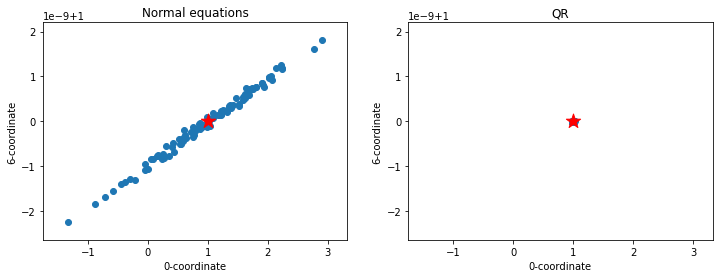

In [26]:
Thetas_hard_qr = run_perturbation_trials(solve_qr, X_hard, y_hard)

# Plot side-by-side against normal equations method
def compare_scatter_thetas(T0, title0, T1, title1, ax=0, ay=1, **kwargs):
    xmin, xmax = calc_lims(np.array([Thetas_hard_neq[ax, :], Thetas_hard_qr[ax, :]]))
    ymin, ymax = calc_lims(np.array([Thetas_hard_neq[ay, :], Thetas_hard_qr[ay, :]]))
    xylim = [xmin, xmax, ymin, ymax]
    figure(figsize=(12, 4))
    subplot(1, 2, 1)
    scatter_thetas(T0, title=title0, ax=ax, ay=ay, xylim=xylim, **kwargs)
    subplot(1, 2 ,2)
    scatter_thetas(T1, title=title1, ax=ax, ay=ay, xylim=xylim, **kwargs)
    
compare_scatter_thetas(Thetas_hard_neq, 'Normal equations',
                       Thetas_hard_qr, 'QR',
                       ax=0, ay=-1, theta_true=theta_hard_true)

print("Sample estimate for one of the trials:")
theta_hard_neq_example = Thetas_hard_neq[:, np.random.randint(Thetas_hard_neq.shape[1])]
theta_hard_qr_example = Thetas_hard_qr[:, np.random.randint(Thetas_hard_qr.shape[1])]
msg = "- {}-based method: theta^T =\n\t{}"
print(msg.format("Gramian", theta_hard_neq_example.T))
print(msg.format("QR", theta_hard_qr_example.T))

You should observe that the QR-based method does, indeed, produce estimates much closer to the true value despite the problem's high condition number.

**Performance tradeoff.** Although QR produces more reliable results, there can be a performance tradeoff, as the following quick test should show.

In [27]:
print("=== Performance of the normal equations-based algorithm ===")
benchit("solve_neq(X_hard, y_hard)", scope=globals());

=== Performance of the normal equations-based algorithm ===


<ipython-input-8-dd77af09b269>:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.8027e-25): result may not be accurate.
  theta_star = scipy.linalg.solve(A, b)


Timing result: (5 trials) x (10000 runs) in 2.2139404219924472 secs
==> 4.4278808439848945e-05 secs per run


In [28]:
print("\n=== Performance of the QR-based algorithm ===")
benchit("solve_qr(X_hard, y_hard)", scope=globals());


=== Performance of the QR-based algorithm ===
Timing result: (5 trials) x (10000 runs) in 3.3519956699892646 secs
==> 6.70399133997853e-05 secs per run


**Summary comment.** The intent of this notebook was to help you appreciate some of the reliability and performance issues involved in the design of numerical algorithms. The key ideas are as follows.

1. The _conditioning_ of a problem, which is a measure of how hard it is to solve. For solving linear systems, the condition number of the matrix produced by `numpy.linalg.cond()` is this measure.
2. For the specific problem of linear least squares, a method based on QR factorization is better than forming the Gram matrix, which squares the condition number. Although we did not discuss the theory of QR better, it exemplifies a common pattern or trick in linear algebraic problems: converting the original problem (or matrix) into one whose structure is easier to solve.
3. There is a potential tradeoff between _reliability_ of an algorithm and _speed_.

Many of these algorithmic and engineering ideas have already been worked out, and are encapsulated in Numpy's built-in [`lstsq()` solver](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) or its [Scipy equivalent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html). So when you need to solve a linear system in a future notebook, you can use this function.

**Fin!** If you've gotten this far without errors, your notebook is ready to submit.